# Function

In [1]:
from math import *
import numpy as np
from astropy.constants import G, c, M_sun
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# 转换为高斯单位制
G = G.cgs.value
c = c.cgs.value
M_sun = M_sun.cgs.value
day = 86400
year = 365*day
pi = np.pi

# 设置系统参数
M_ns = 1.4 * M_sun
R_ns = 1e6
B_list = [1e14, 5e13]
I = 1e45
M_ej_list = [3 * M_sun, 5 * M_sun, 10 * M_sun]
P_0_list = [1e-3, 10e-3]
kappa = 0.1
kappa_gamma = 0.1
E_int_0 = 1e35
E_sn = 1e51
type_list = ['I', 'II', 'III']

# 引力波辐射功率相关参数
epsilon_list = [1e-3, 5e-4, 1e-4]
alpha_list = [0.1, 0.05, 0.01]
J_tilde = 0.01635
I_tilde = 0.261

# 计算热光度的函数
def L_bol(type, B=1e14, M_ej=M_ej_list[1], Omega_0=2 * pi / P_0_list[0], epsilon=epsilon_list[0], alpha=alpha_list[0]):
    """
    Compute bolometric luminosity of an SN.

    :param type: type of radiation mechanism
    :param R_ns: radius of neutron star
    :param Omega_0: initial rotational rate of neutron star
    :param I: moment of inertia
    :return: [t_array, L_bol_array, eta_array]
    """
    # 设置初始参数
    v_ej_0 = sqrt(2 * (E_int_0 + E_sn) / M_ej)
    R_ej_0 = v_ej_0 * 1e-3
    beta = B**2 * R_ns**6 / (6 * c**3 * I)
    gamma_e = 32 * G * I * epsilon**2 / (5 * c**5)
    gamma_r = (96 * pi / 15**2) * (4 / 3)**6 * G * M_ns * R_ns**4 * J_tilde**2 / (c**7 * I_tilde) * alpha**2
    def func(t, y):
        """
        The function to put in solve_ivp.

        :param t: time array of the SN explosion
        :param y: list of needed variables, which are Omega, v, E_int, R
        :return: list of dy/dt
        """
        Omega, v_ej, E_int, R_ej = y[0], y[1], y[2], y[3]
        if type == 'I':
            dOmega_dt = - beta * Omega**3
        elif type == 'II':
            dOmega_dt = - beta * Omega**3 - gamma_e * Omega**5
        elif type == 'III':
            dOmega_dt = - beta * Omega**3 - gamma_r * Omega**7
        else:
            raise NotImplementedError

        a_value = 3 * kappa_gamma * M_ej / (4 * pi * R_ej**2)
        eta = 1 - np.exp(- a_value)     # 高能光子泄露因子
        L_EM = beta * I * Omega**4        # 电磁辐射功率
        tau = 3 * kappa * M_ej / (4 * pi * R_ej**2)     # 光深
        p = E_int / (4 * pi * R_ej**3)      # 辐射压
        dR_ej_dt = v_ej
        dv_ej_dt = 4 * pi * R_ej**2 * p / M_ej      # 牛顿第二定律
        L_bol = c * E_int * (1 - np.exp(-tau)) / (R_ej * tau)       # 热光度

        dE_int_dt = eta * L_EM - L_bol - 4 * pi * R_ej**2 * p * v_ej
        return [dOmega_dt, dv_ej_dt, dE_int_dt, dR_ej_dt]

    t_return = 10**(np.linspace(-3, log(500*day, 10), 10**4))
    sol = solve_ivp(func, t_span=[1e-3, 5*year], y0=[Omega_0, v_ej_0, E_int_0, R_ej_0],
                    t_eval=t_return, method='DOP853', rtol=10**(-9))
    # 提取求解后的值并且计算所需的量
    t_array = sol.t
    E_int_array = sol.y[2]
    R_ej_array = sol.y[3]
    tau_array = 3 * kappa * M_ej / (4 * pi * R_ej_array**2)
    L_bol_array = c * E_int_array * (1 - np.exp(-tau_array)) / (R_ej_array * tau_array)
    return [t_array, L_bol_array]

# $B$ plot

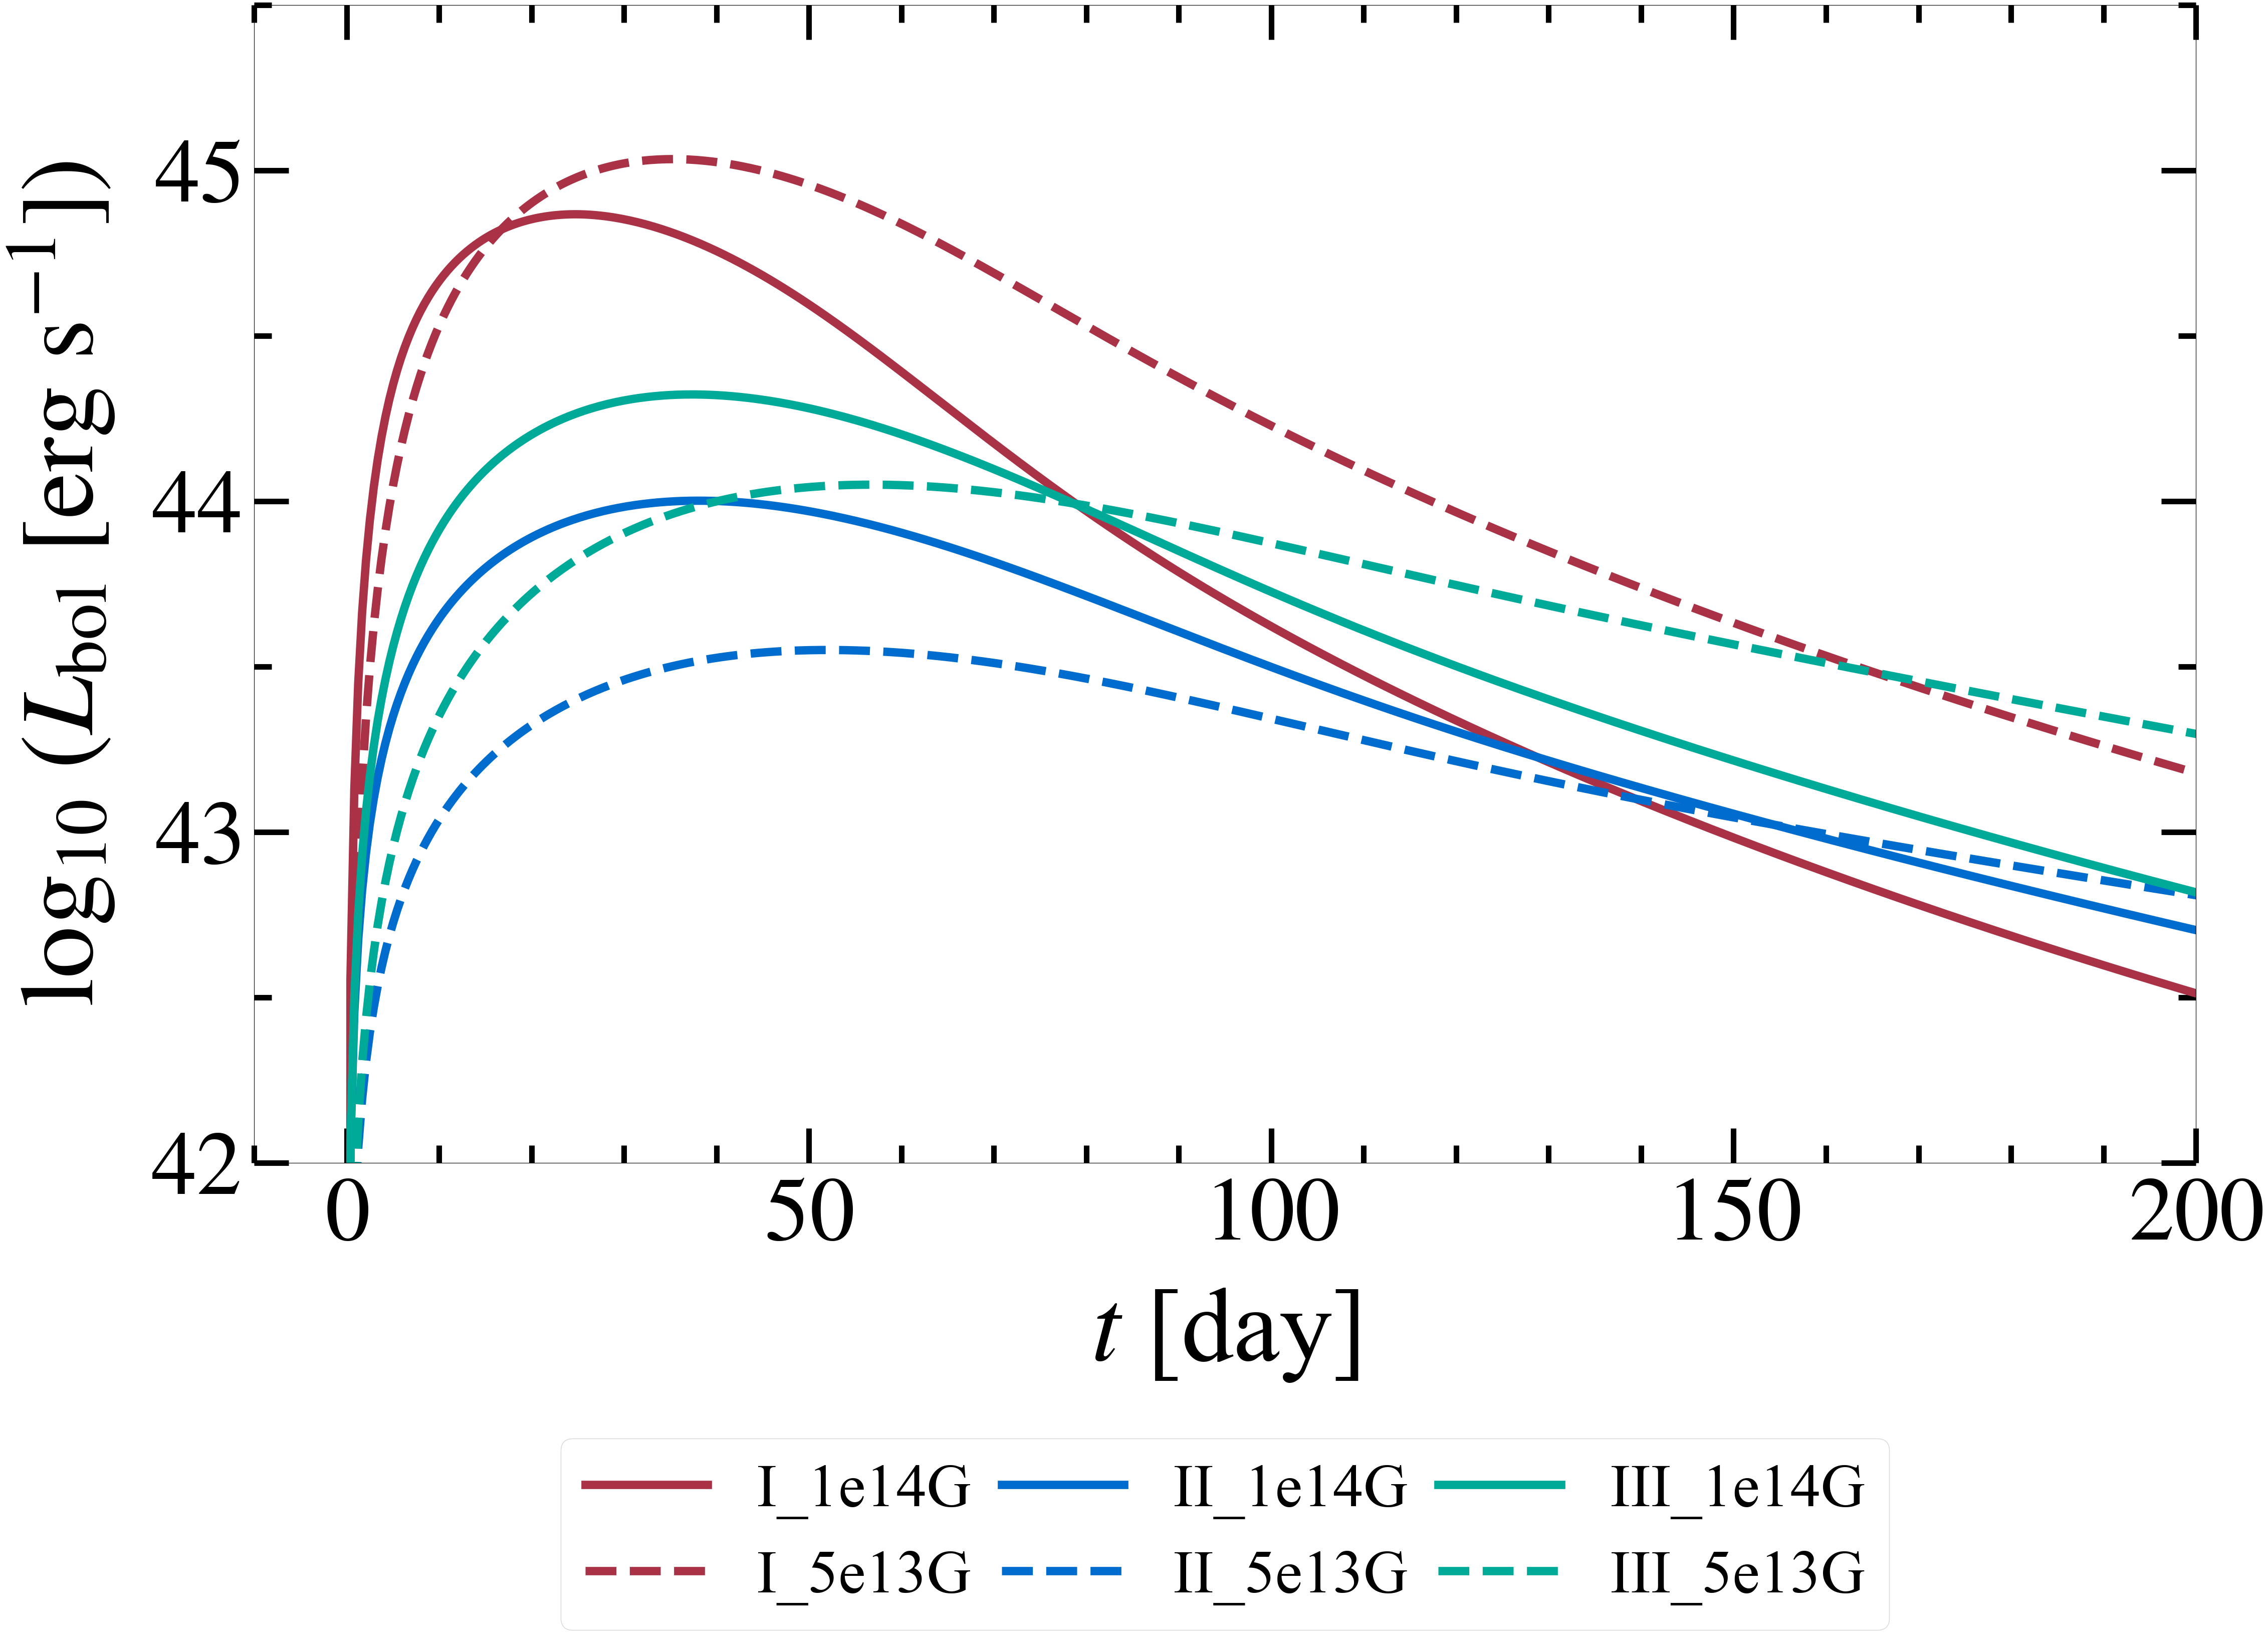

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd

# 设置画图的全局要求
plt.rcParams['font.family'] = 'Times New Roman'         # 文字字体
plt.rcParams['mathtext.fontset'] = 'stix'       # 数字字体
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'      # 刻度线朝向
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(8, 6))        # 创建 2 行 1 列的子图
fig.set_size_inches(50, 30)

# 设置 xy 轴的取值范围
ax1.set_xlim(-10, 200)
ax1.set_ylim(42, 45.5)
# 设置 xy 轴的刻度间距
x_major_locator = MultipleLocator(50)
x_minor_locator = MultipleLocator(10)
ax1.xaxis.set_major_locator(x_major_locator)
ax1.xaxis.set_minor_locator(x_minor_locator)
y1_major_locator = MultipleLocator(1)
y1_minor_locator = MultipleLocator(0.5)
ax1.yaxis.set_major_locator(y1_major_locator)
ax1.yaxis.set_minor_locator(y1_minor_locator)
# 设置 xy 轴的标签以及刻度
ax1.set_xticks([0, 50, 100, 150, 200],
               [r'$0$', r'$50$', r'$100$', r'$150$', r'$200$'], size=130)
ax1.set_yticks([42, 43, 44, 45],
               [r'$42$', r'$43$', r'$44$', r'$45$'], size=130)
ax1.set_xlabel(r'$t$ [day]', fontsize=150, labelpad=40)
ax1.set_ylabel(r'$\mathrm{log}_{10}~(L_\mathrm{bol} ~ [\mathrm{erg ~ s}^{-1}])$', fontsize=150, labelpad=50)
ax1.tick_params(axis='both', which='major', length=50, width=8, pad=20, top=True, right=True)
ax1.tick_params(axis='both', which='minor', length=25, width=8, pad=20, top=True, right=True)

# 画图
style_list = ['-', '--', '-.']
color_list = ['#A93246', '#006CCE', '#00AA99']
legend_list = ['1e14G', '5e13G']
t_plot = np.linspace(1e-3, 420*day, 10**3)
for i in range(len(type_list)):
    for j in range(len(B_list)):
        t_array, L_bol_array = L_bol(type_list[i], B=B_list[j], M_ej=M_ej_list[1], Omega_0=2 * pi / P_0_list[0], epsilon=epsilon_list[0], alpha=alpha_list[0])
        L_plot = interp1d(t_array, L_bol_array, kind='cubic', fill_value='extrapolate')
        ax1.plot(t_plot / day, np.array([log(L_plot(i), 10) for i in t_plot]), label=f"{type_list[i]}_{legend_list[j]}", linestyle=style_list[j], color=color_list[i], linewidth=12)

ax1.legend(fontsize=88, ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.43), columnspacing=0.5)
# plt.savefig('B_vary.pdf', bbox_inches='tight')

data_dict = {}
for line in ax1.get_lines():
    xd, yd = line.get_data()
    lname = f"{line.get_label()}"
    data_dict[lname] = yd
    data_dict['time'] = xd

df = pd.DataFrame(data_dict)
df.to_csv('fig_6.csv', index=False)

# $M_\mathrm{ej}$ plot

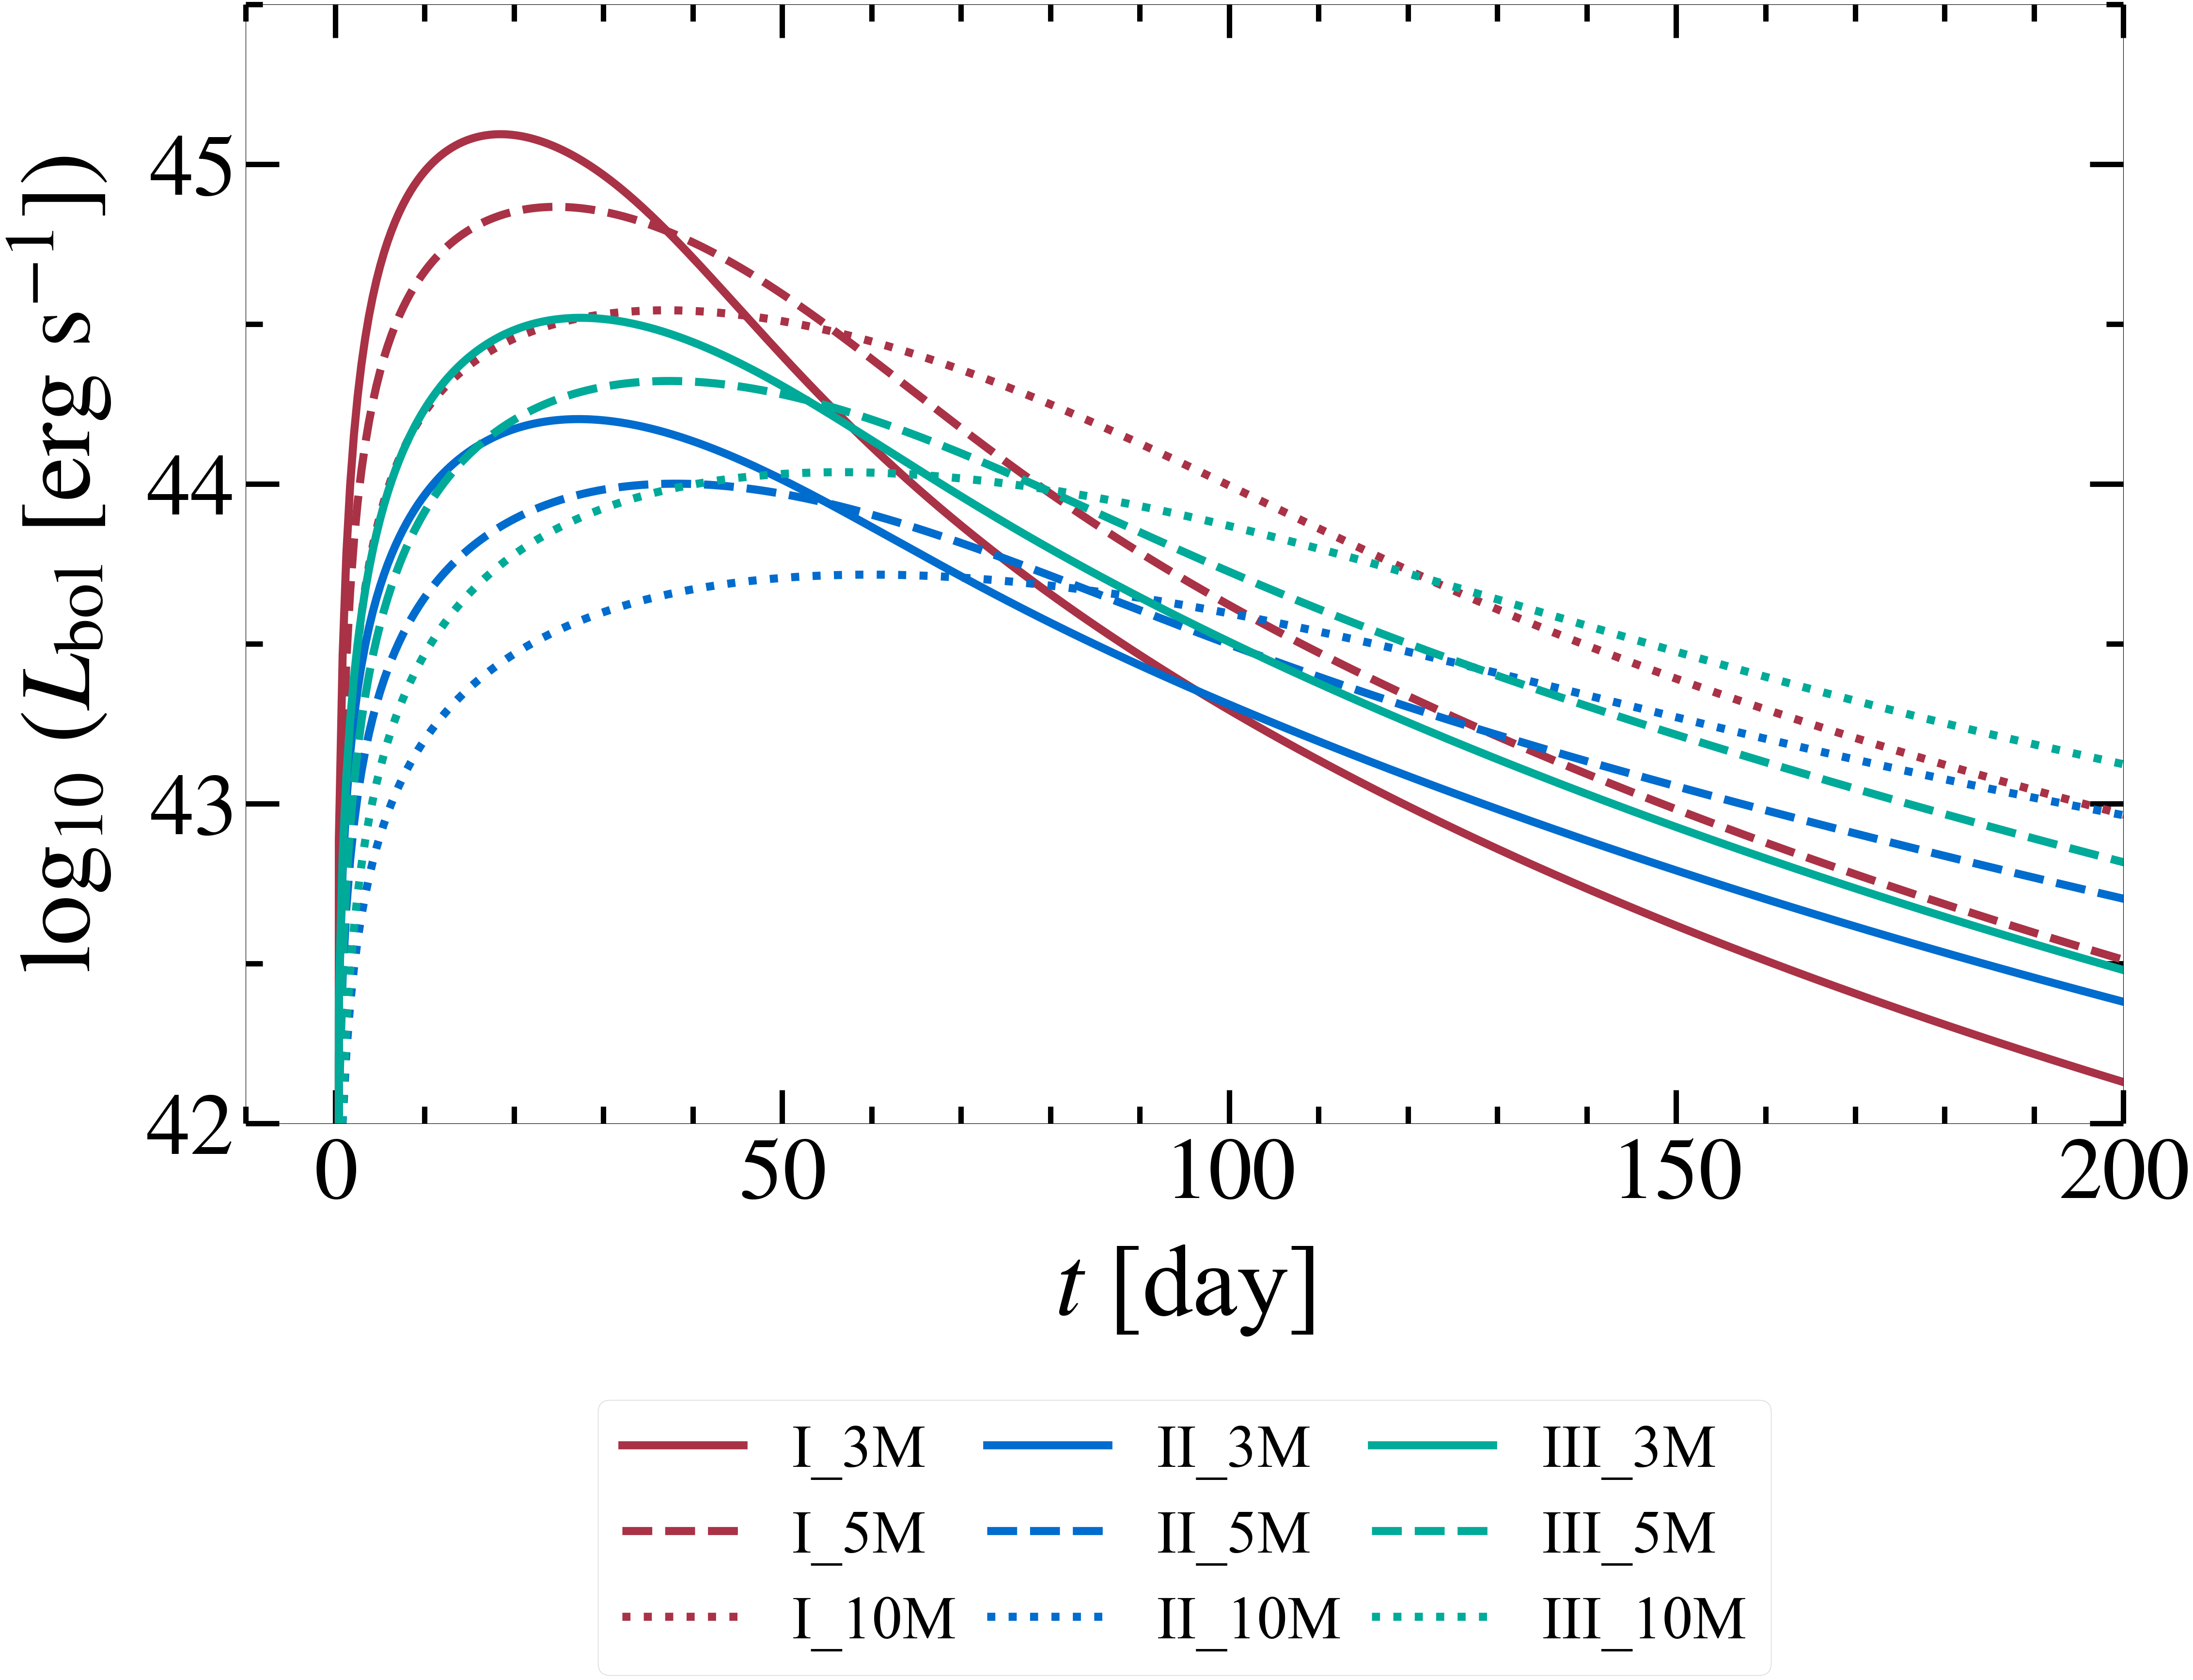

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# 设置画图的全局要求
plt.rcParams['font.family'] = 'Times New Roman'         # 文字字体
plt.rcParams['mathtext.fontset'] = 'stix'       # 数字字体
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'      # 刻度线朝向
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(8, 6))        # 创建 2 行 1 列的子图
fig.set_size_inches(50, 30)

# 设置 xy 轴的取值范围
ax1.set_xlim(-10, 200)
ax1.set_ylim(42, 45.5)
# 设置 xy 轴的刻度间距
x_major_locator = MultipleLocator(50)
x_minor_locator = MultipleLocator(10)
ax1.xaxis.set_major_locator(x_major_locator)
ax1.xaxis.set_minor_locator(x_minor_locator)
y1_major_locator = MultipleLocator(1)
y1_minor_locator = MultipleLocator(0.5)
ax1.yaxis.set_major_locator(y1_major_locator)
ax1.yaxis.set_minor_locator(y1_minor_locator)
# 设置 xy 轴的标签以及刻度
ax1.set_xticks([0, 50, 100, 150, 200],
               [r'$0$', r'$50$', r'$100$', r'$150$', r'$200$'], size=130)
ax1.set_yticks([42, 43, 44, 45],
               [r'$42$', r'$43$', r'$44$', r'$45$'], size=130)
ax1.set_xlabel(r'$t$ [day]', fontsize=150, labelpad=40)
ax1.set_ylabel(r'$\mathrm{log}_{10}~(L_\mathrm{bol} ~ [\mathrm{erg~ s}^{-1}])$', fontsize=150, labelpad=50)
ax1.tick_params(axis='both', which='major', length=50, width=8, pad=20, top=True, right=True)
ax1.tick_params(axis='both', which='minor', length=25, width=8, pad=20, top=True, right=True)

# 画图
style_list = ['-', '--', ':']
color_list = ['#A93246', '#006CCE', '#00AA99']
legend_list = ['3M', '5M', '10M']
t_plot = np.linspace(1e-3, 420*day, 10**3)
for i in range(len(type_list)):
    for j in range(len(M_ej_list)):
        t_array, L_bol_array = L_bol(type_list[i], B=B_list[0], M_ej=M_ej_list[j], Omega_0=2 * pi / P_0_list[0], epsilon=epsilon_list[0], alpha=alpha_list[0])
        L_plot = interp1d(t_array, L_bol_array, kind='cubic', fill_value='extrapolate')
        ax1.plot(t_plot / day, np.array([log(L_plot(i), 10) for i in t_plot]), label=f"{type_list[i]}_{legend_list[j]}", linestyle=style_list[j], color=color_list[i], linewidth=12)

ax1.legend(fontsize=90, ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.52), columnspacing=0.5)
# plt.savefig('M_ej_vary.pdf', bbox_inches='tight')

data_dict = {}
for line in ax1.get_lines():
    xd, yd = line.get_data()
    lname = f"{line.get_label()}"
    data_dict[lname] = yd
    data_dict['time'] = xd

df = pd.DataFrame(data_dict)
df.to_csv('fig_7.csv', index=False)

# $\varepsilon-\alpha$ plot

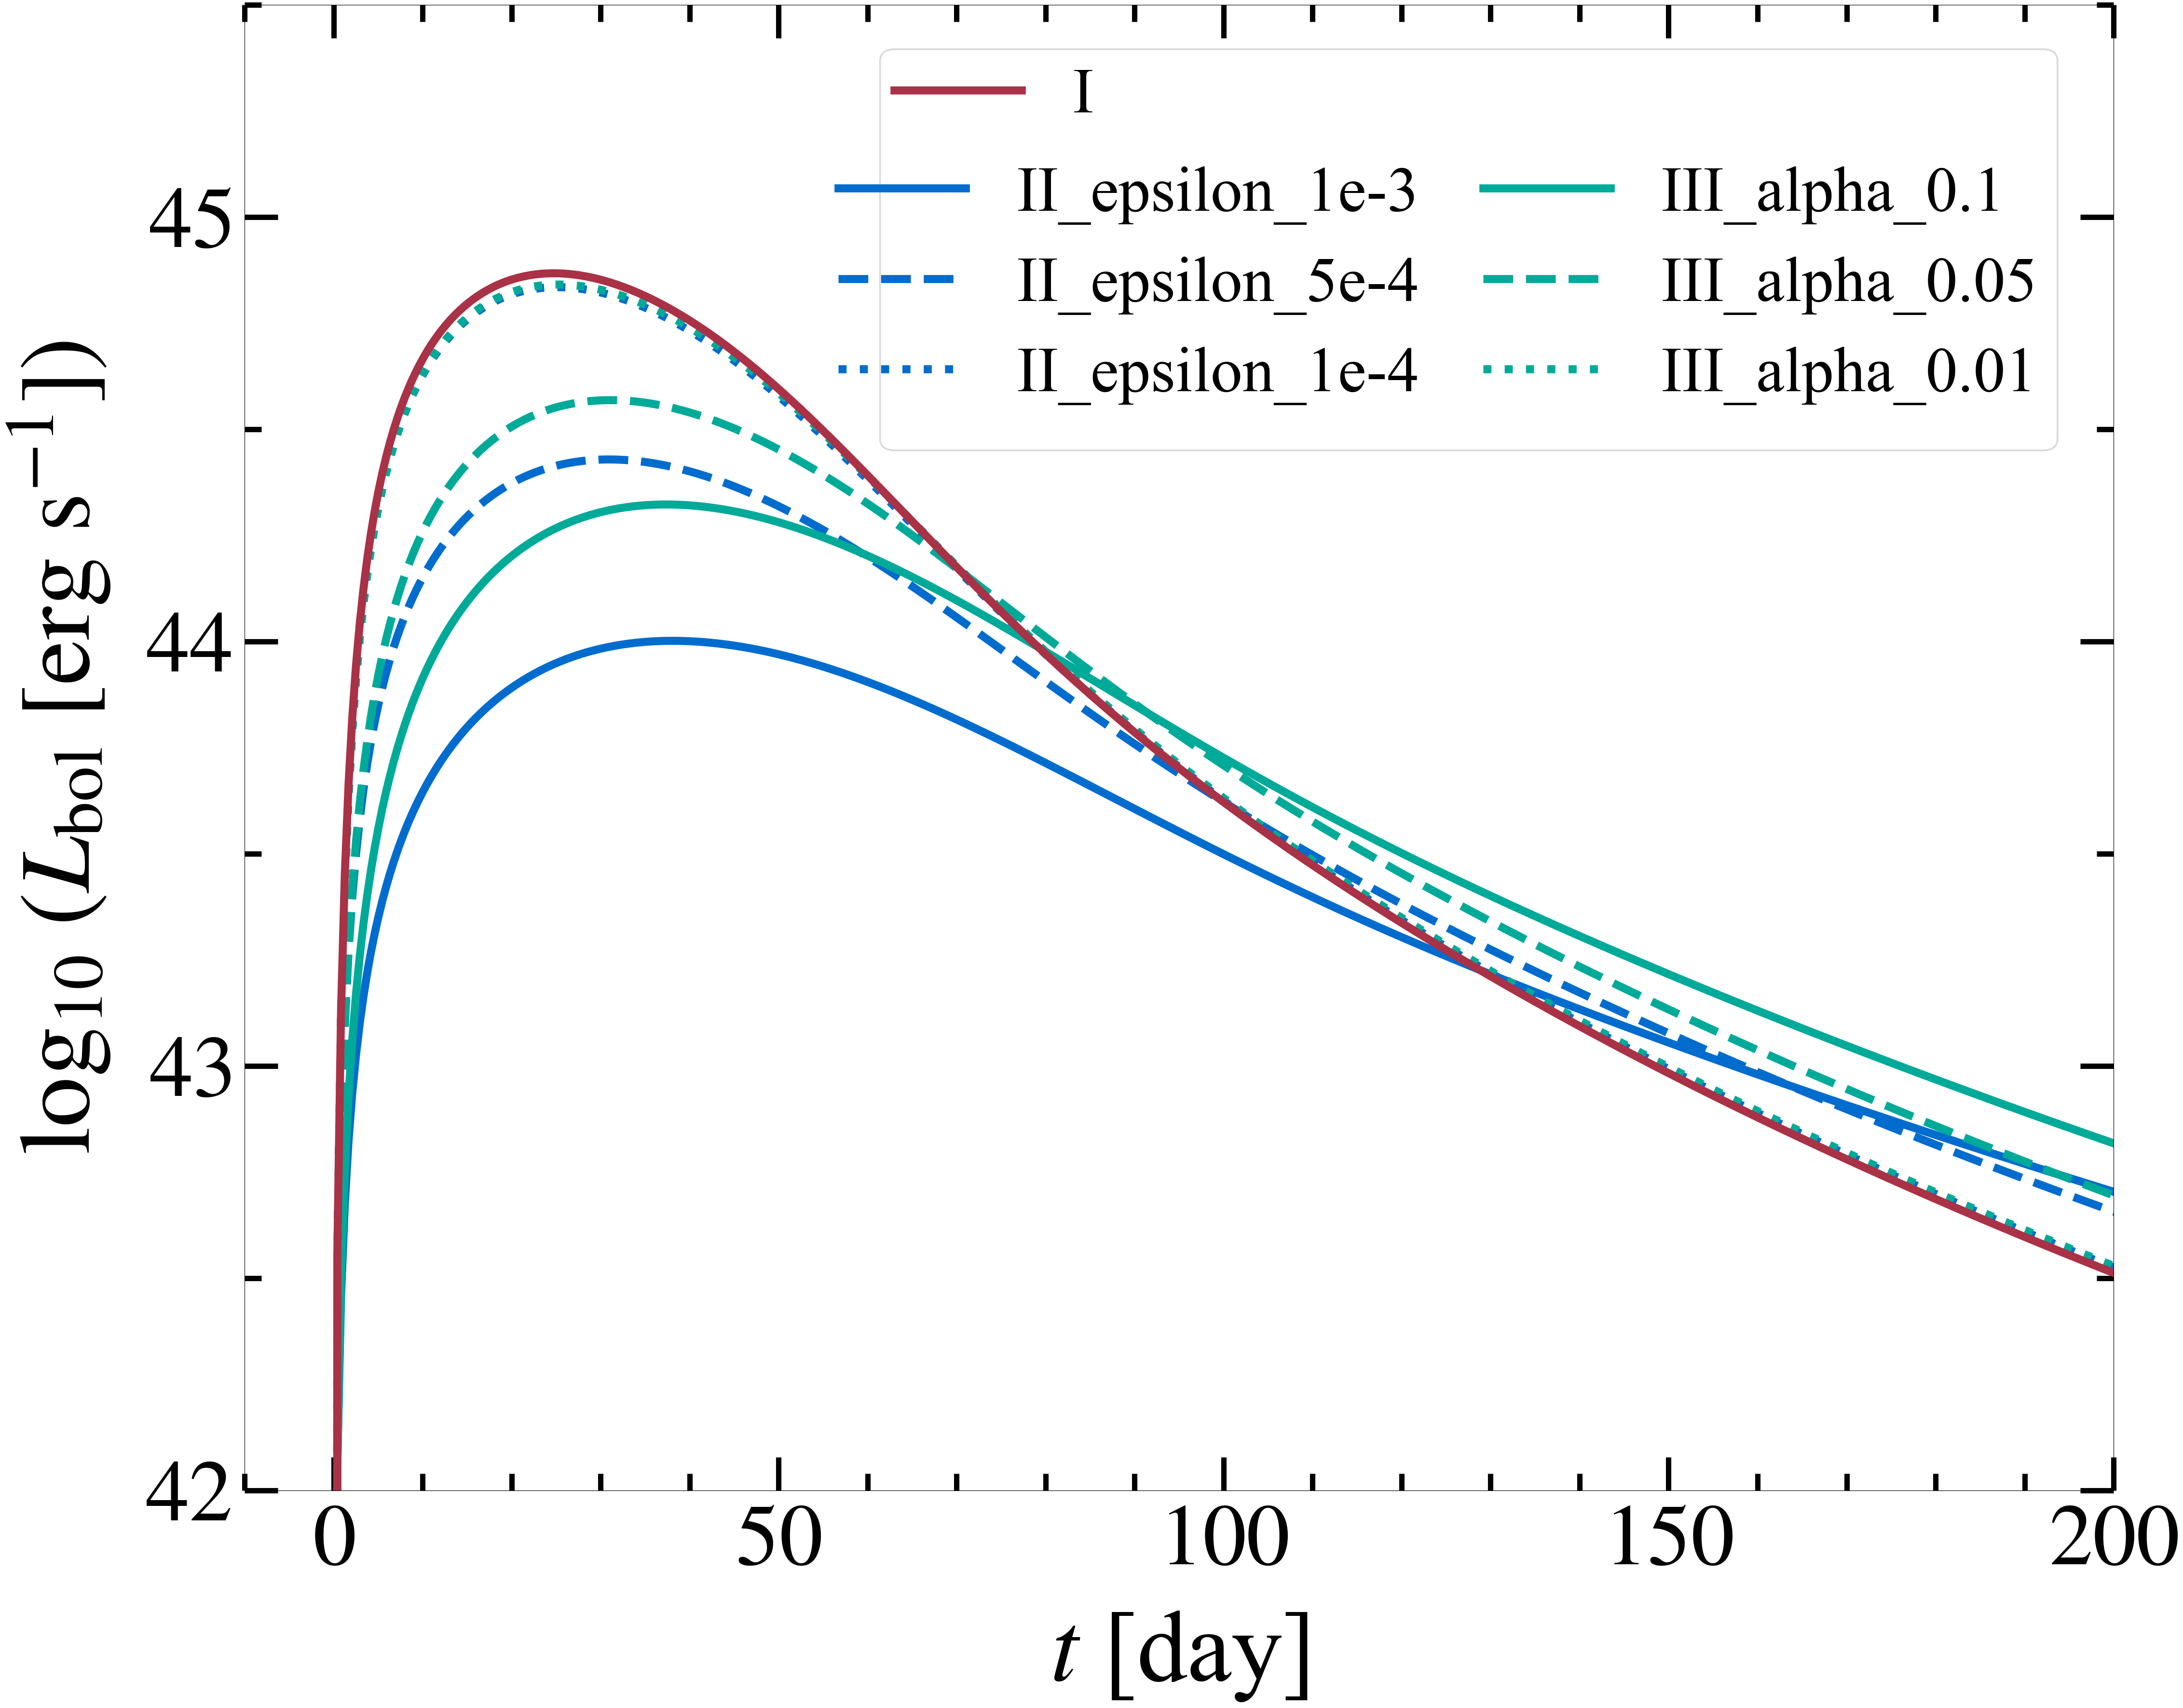

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import FancyBboxPatch

# 设置画图的全局要求
plt.rcParams['font.family'] = 'Times New Roman'         # 文字字体
plt.rcParams['mathtext.fontset'] = 'stix'       # 数字字体
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'      # 刻度线朝向
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(8, 6))        # 创建 2 行 1 列的子图
fig.set_size_inches(50, 40)

# 设置 xy 轴的取值范围
ax1.set_xlim(-10, 200)
ax1.set_ylim(42, 45.5)
# 设置 xy 轴的刻度间距
x_major_locator = MultipleLocator(50)
x_minor_locator = MultipleLocator(10)
ax1.xaxis.set_major_locator(x_major_locator)
ax1.xaxis.set_minor_locator(x_minor_locator)
y1_major_locator = MultipleLocator(1)
y1_minor_locator = MultipleLocator(0.5)
ax1.yaxis.set_major_locator(y1_major_locator)
ax1.yaxis.set_minor_locator(y1_minor_locator)
# 设置 xy 轴的标签以及刻度
ax1.set_xticks([0, 50, 100, 150, 200],
               [r'$0$', r'$50$', r'$100$', r'$150$', r'$200$'], size=130)
ax1.set_yticks([42, 43, 44, 45],
               [r'$42$', r'$43$', r'$44$', r'$45$'], size=130)
ax1.set_xlabel(r'$t$ [day]', fontsize=150, labelpad=40)
ax1.set_ylabel(r'$\mathrm{log}_{10}~(L_\mathrm{bol} ~ [\mathrm{erg ~ s}^{-1}])$', fontsize=150, labelpad=50)
ax1.tick_params(axis='both', which='major', length=50, width=8, pad=20, top=True, right=True)
ax1.tick_params(axis='both', which='minor', length=25, width=8, pad=20, top=True, right=True)

# 画图
style_list = ['-', '--', ':']
color_list = ['#A93246', '#006CCE', '#00AA99']
e_legend_list = [r'epsilon_1e-3', r'epsilon_5e-4', r'epsilon_1e-4']
r_legend_list = [r'alpha_0.1', r'alpha_0.05', r'alpha_0.01']
t_plot = np.linspace(1e-3, 420*day, 10**3)

# Create a rounded rectangle
rounded_rect = FancyBboxPatch(
    (0.44, 0.8),            # (x, y) of bottom-left corner
    0.43, 0.07,              # width and height
    transform=ax1.transAxes,
    boxstyle="round,pad=0.1,rounding_size=0.008",  # curved corners
    linewidth=2.5,
    edgecolor='grey',
    facecolor='none',
    alpha=0.3
)
ax1.add_patch(rounded_rect)

for i in range(len(type_list)):
    if i==1:
        for j in range(len(epsilon_list)):
            t_array, L_bol_array = L_bol(type_list[i], B=B_list[0], M_ej=M_ej_list[1], Omega_0=2 * pi / P_0_list[0], epsilon=epsilon_list[j], alpha=alpha_list[j])
            L_plot = interp1d(t_array, L_bol_array, kind='cubic', fill_value='extrapolate')
            ax1.plot(t_plot / day, np.array([log(L_plot(i), 10) for i in t_plot]), label=f"{type_list[i]}_{e_legend_list[j]}", linestyle=style_list[j], color=color_list[i], linewidth=12)
    if i==2:
        for j in range(len(epsilon_list)):
            t_array, L_bol_array = L_bol(type_list[i], B=B_list[0], M_ej=M_ej_list[1], Omega_0=2 * pi / P_0_list[0], epsilon=epsilon_list[j], alpha=alpha_list[j])
            L_plot = interp1d(t_array, L_bol_array, kind='cubic', fill_value='extrapolate')
            ax1.plot(t_plot / day, np.array([log(L_plot(i), 10) for i in t_plot]), label=f"{type_list[i]}_{r_legend_list[j]}", linestyle=style_list[j], color=color_list[i], linewidth=12)
legend1 = ax1.legend(fontsize=95, ncol=2, loc='upper right', bbox_to_anchor=(0.99, 0.93), columnspacing=1, frameon=False)
ax1.add_artist(legend1)

for i in range(len(type_list)):
    if i==0:
        t_array, L_bol_array = L_bol(type_list[i], B=B_list[0], M_ej=M_ej_list[1], Omega_0=2 * pi / P_0_list[0], epsilon=epsilon_list[j], alpha=alpha_list[j])
        L_plot = interp1d(t_array, L_bol_array, kind='cubic', fill_value='extrapolate')
        line1, = ax1.plot(t_plot / day, np.array([log(L_plot(i), 10) for i in t_plot]), label=f"{type_list[i]}", linestyle=style_list[0], color=color_list[i], linewidth=12)
        legend2 = ax1.legend(fontsize=95, ncol=2, loc='upper right', bbox_to_anchor=(0.485, 0.996), columnspacing=0.55, handles=[line1], frameon=False)

# plt.savefig('GW_vary.pdf', bbox_inches='tight')

data_dict = {}
for line in ax1.get_lines():
    xd, yd = line.get_data()
    lname = f"{line.get_label()}"
    data_dict[lname] = yd
    data_dict['time'] = xd

df = pd.DataFrame(data_dict)
df.to_csv('fig_8.csv', index=False)

# $P-\Omega$ plot

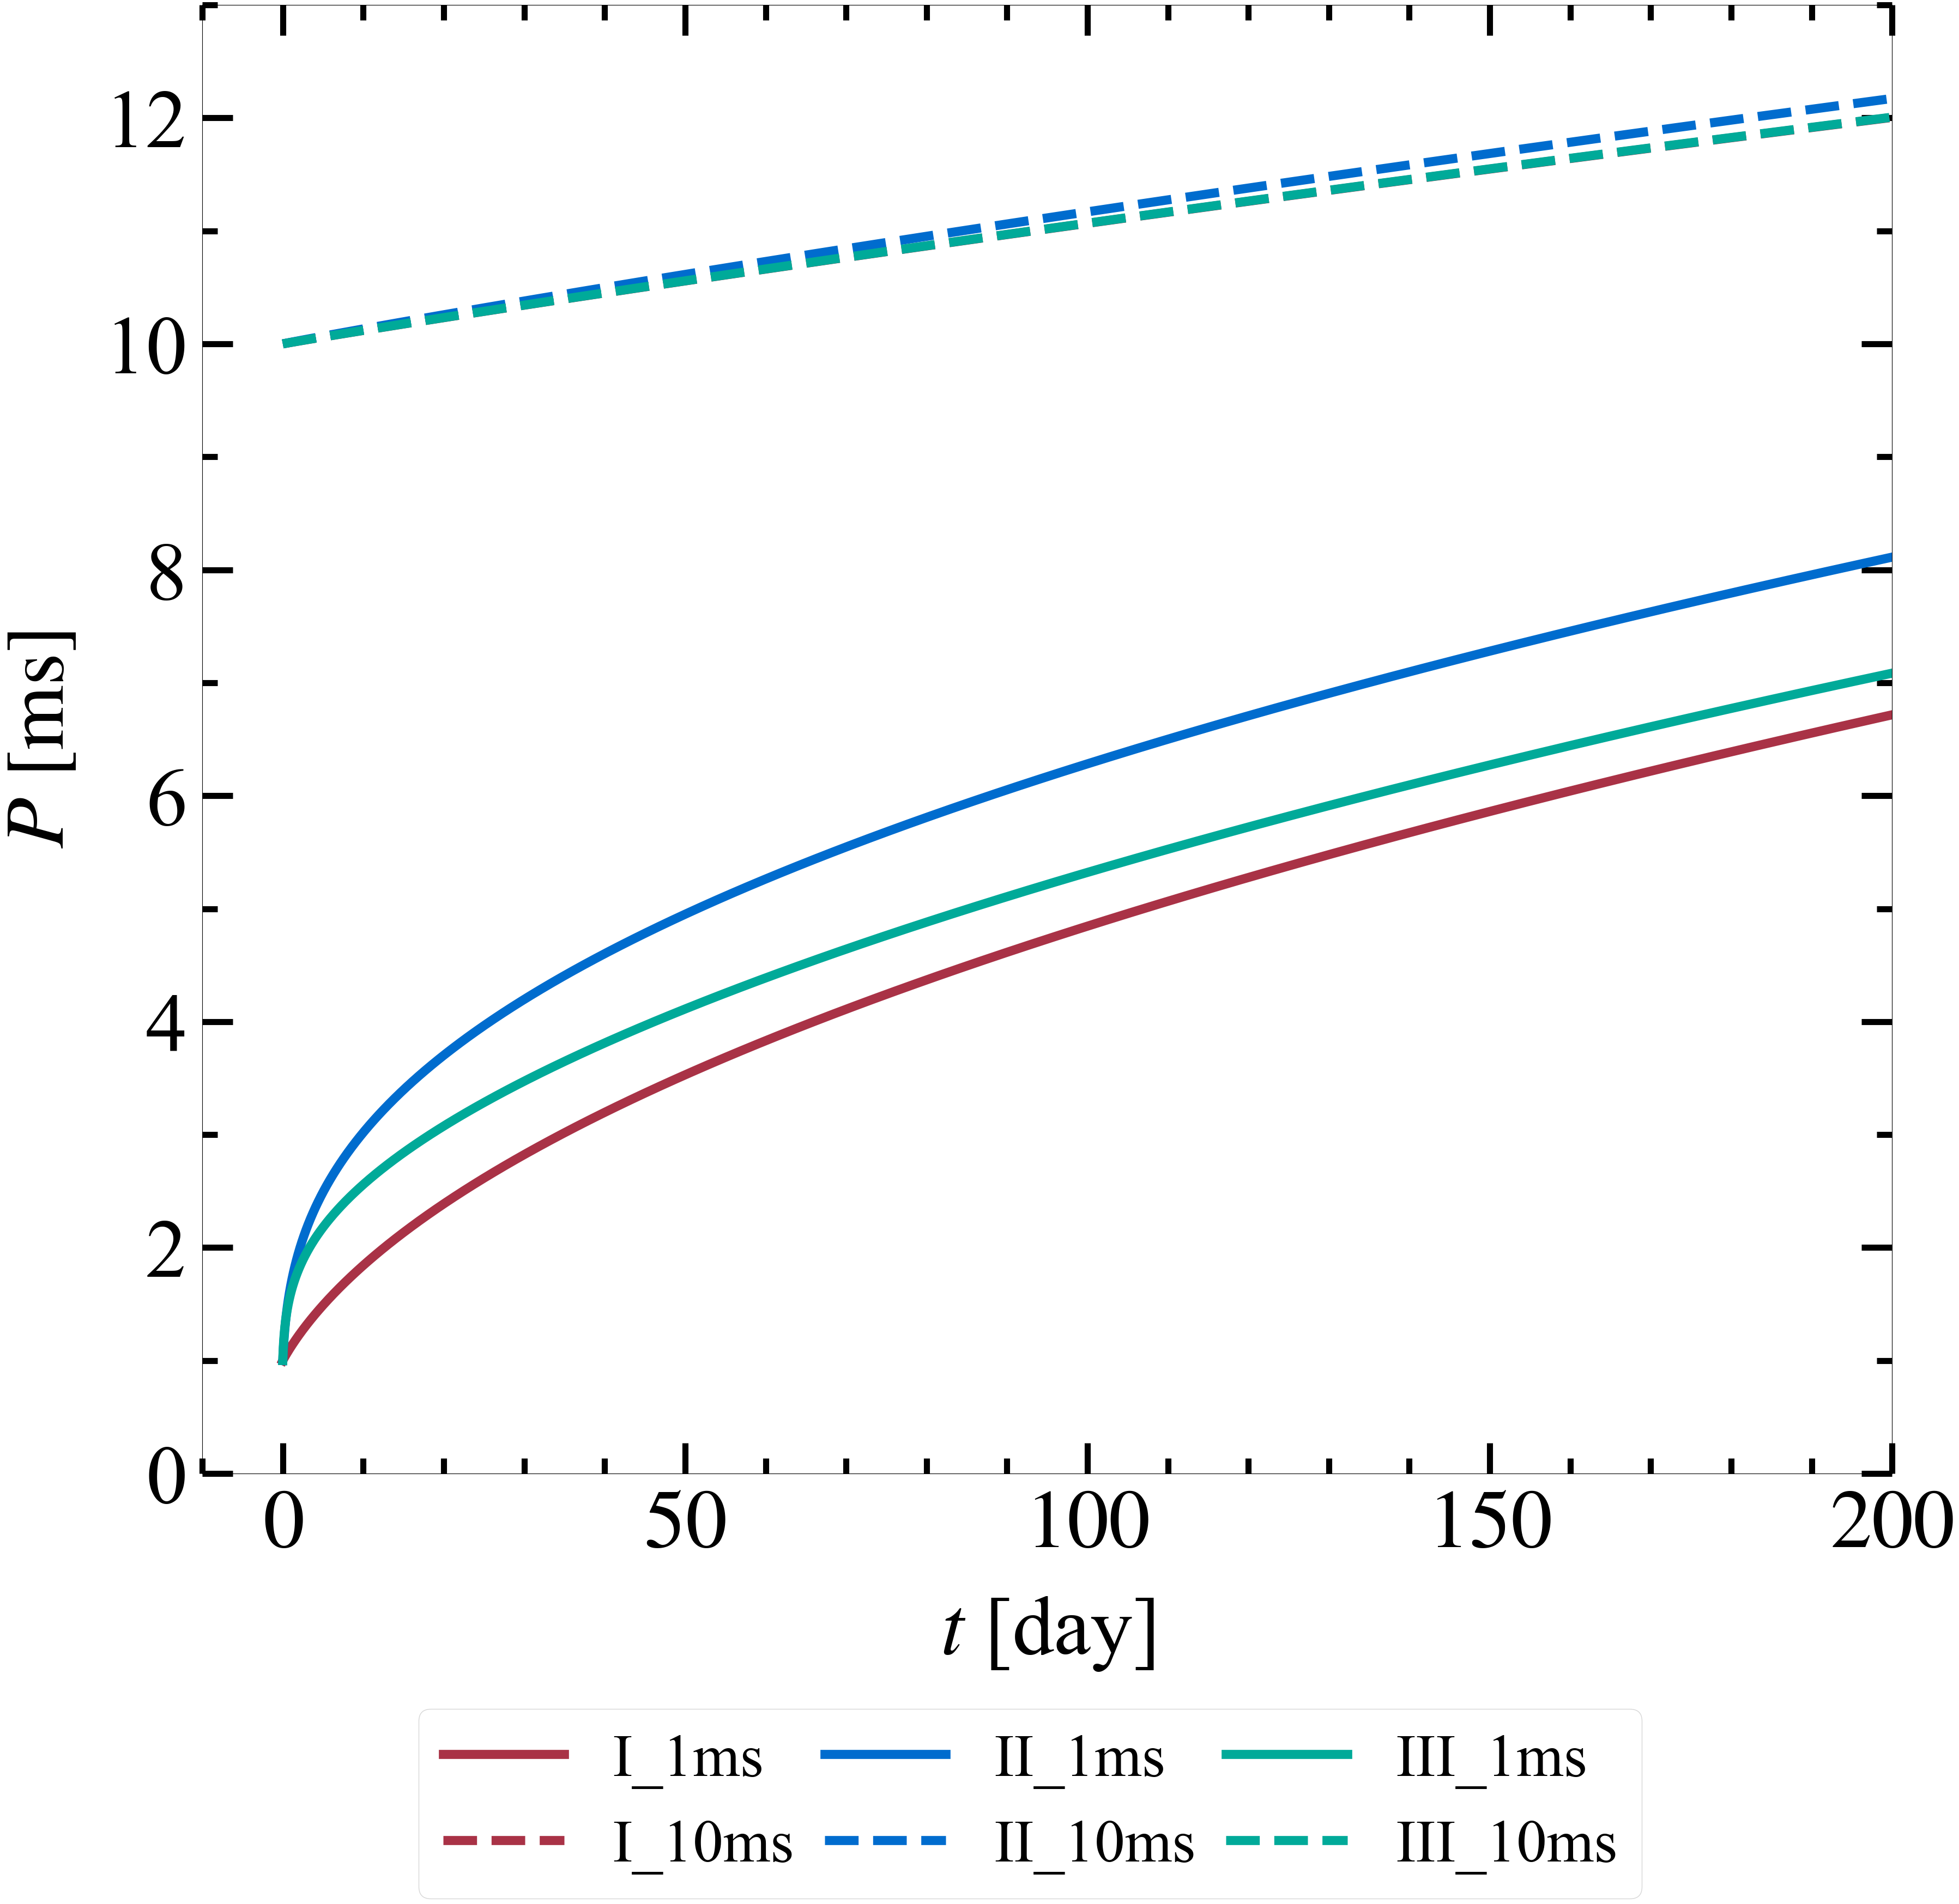

In [7]:
from math import *
import numpy as np
from astropy.constants import G, c, M_sun
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# 转换为高斯单位制
G = G.cgs.value
c = c.cgs.value
M_sun = M_sun.cgs.value
day = 86400
year = 365*day
pi = np.pi

# 设置系统参数
M_ns = 1.4 * M_sun
R_ns = 1e6
B_list = [1e14, 5e13]
I = 1e45
M_ej_list = [3 * M_sun, 5 * M_sun, 10 * M_sun]
P_0_list = [1e-3, 10e-3]
kappa = 0.1
kappa_gamma = 0.1
E_int_0 = 1e35
E_sn = 1e51
type_list = ['I', 'II', 'III']

# 引力波辐射功率相关参数
epsilon_list = [1e-3, 5e-4, 1e-4]
alpha_list = [0.1, 0.05, 0.01]
J_tilde = 0.01635
I_tilde = 0.261

# 计算热光度的函数
def L_bol(type, B=1e14, M_ej=M_ej_list[1], Omega_0=2 * pi / P_0_list[0], epsilon=epsilon_list[0], alpha=alpha_list[0]):
    """
    Compute bolometric luminosity of an SN.

    :param type: type of radiation mechanism
    :param R_ns: radius of neutron star
    :param Omega_0: initial rotational rate of neutron star
    :param I: moment of inertia
    :return: [t_array, L_bol_array, eta_array]
    """
    # 设置初始参数
    v_ej_0 = sqrt(2 * (E_int_0 + E_sn) / M_ej)
    R_ej_0 = v_ej_0 * 1e-3
    beta = B**2 * R_ns**6 / (6 * c**3 * I)
    gamma_e = 32 * G * I * epsilon**2 / (5 * c**5)
    gamma_r = (96 * pi / 15**2) * (4 / 3)**6 * G * M_ns * R_ns**4 * J_tilde**2 / (c**7 * I_tilde) * alpha**2
    def func(t, y):
        """
        The function to put in solve_ivp.

        :param t: time array of the SN explosion
        :param y: list of needed variables, which are Omega, v, E_int, R
        :return: list of dy/dt
        """
        Omega, v_ej, E_int, R_ej = y[0], y[1], y[2], y[3]
        if type == 'I':
            dOmega_dt = - beta * Omega**3
        elif type == 'II':
            dOmega_dt = - beta * Omega**3 - gamma_e * Omega**5
        elif type == 'III':
            dOmega_dt = - beta * Omega**3 - gamma_r * Omega**7
        else:
            raise NotImplementedError

        a_value = 3 * kappa_gamma * M_ej / (4 * pi * R_ej**2)
        eta = 1 - np.exp(- a_value)     # 高能光子泄露因子
        L_EM = beta * I * Omega**4        # 电磁辐射功率
        tau = 3 * kappa * M_ej / (4 * pi * R_ej**2)     # 光深
        p = E_int / (4 * pi * R_ej**3)      # 辐射压
        dR_ej_dt = v_ej
        dv_ej_dt = 4 * pi * R_ej**2 * p / M_ej      # 牛顿第二定律
        L_bol = c * E_int * (1 - np.exp(-tau)) / (R_ej * tau)       # 热光度

        dE_int_dt = eta * L_EM - L_bol - 4 * pi * R_ej**2 * p * v_ej
        return [dOmega_dt, dv_ej_dt, dE_int_dt, dR_ej_dt]

    t_return = 10**(np.linspace(-3, log(500*day, 10), 10**4))
    sol = solve_ivp(func, t_span=[1e-3, 5*year], y0=[Omega_0, v_ej_0, E_int_0, R_ej_0],
                    t_eval=t_return, method='DOP853', rtol=10**(-9))
    # 提取求解后的值并且计算所需的量
    t_array = sol.t
    Omega_array = sol.y[0]
    return [t_array, Omega_array]

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# 设置画图的全局要求
plt.rcParams['font.family'] = 'Times New Roman'         # 文字字体
plt.rcParams['mathtext.fontset'] = 'stix'       # 数字字体
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'      # 刻度线朝向
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(8, 6))        # 创建 2 行 1 列的子图
fig.set_size_inches(40, 35)

# 设置 xy 轴的取值范围
ax1.set_xlim(-10, 200)
ax1.set_ylim(0, 13)
# 设置 xy 轴的刻度间距
x_major_locator = MultipleLocator(50)
x_minor_locator = MultipleLocator(10)
ax1.xaxis.set_major_locator(x_major_locator)
ax1.xaxis.set_minor_locator(x_minor_locator)
y1_major_locator = MultipleLocator(2)
y1_minor_locator = MultipleLocator(1)
ax1.yaxis.set_major_locator(y1_major_locator)
ax1.yaxis.set_minor_locator(y1_minor_locator)
# 设置 xy 轴的标签以及刻度
ax1.set_xticks([0, 50, 100, 150, 200],
               [r'$0$', r'$50$', r'$100$', r'$150$', r'$200$'], size=110)
ax1.set_yticks([0, 2, 4, 6, 8, 10, 12],
               [0, 2, 4, 6, 8, 10, 12], size=110)
ax1.set_xlabel(r'$t$ [day]', fontsize=110, labelpad=40)
ax1.set_ylabel(r'$P ~ [\mathrm{ms}]$', fontsize=110, labelpad=30)
ax1.tick_params(axis='both', which='major', length=40, width=8, pad=20, top=True, right=True)
ax1.tick_params(axis='both', which='minor', length=20, width=8, pad=20, top=True, right=True)

# plt.xscale('log')
# plt.yscale('log')

# 画图
style_list = ['-', '--', '-.']
color_list = ['#A93246', '#006CCE', '#00AA99']
legend_list = [r'1ms', r'10ms']
t_plot = np.logspace(-3, log(1000*day, 10), 10**4)
for i in range(len(type_list)):
    for j in range(len(P_0_list)):
        t_array, Omega_array = L_bol(type_list[i], B=B_list[0], M_ej=M_ej_list[1], Omega_0=2 * pi / P_0_list[j], epsilon=epsilon_list[0], alpha=alpha_list[0])
        L_plot = interp1d(t_array, 2 * pi / Omega_array, kind='cubic', fill_value='extrapolate')
        ax1.plot(t_plot / day, 2e3 * pi / Omega_array, label=f"{type_list[i]}_{legend_list[j]}", linestyle=style_list[j], color=color_list[i], linewidth=12)

ax1.legend(fontsize=80, ncol=3, loc='lower center', bbox_to_anchor=(0.49, -0.31), columnspacing=0.5)
# plt.savefig('Period_lin.pdf', bbox_inches='tight')

data_dict = {}
for line in ax1.get_lines():
    xd, yd = line.get_data()
    lname = f"{line.get_label()}"
    data_dict[lname] = yd
    data_dict['time'] = xd

df = pd.DataFrame(data_dict)
df.to_csv('fig_1.csv', index=False)